# Classification Neural Network  


In [1]:
'''Needed Packages'''
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
#from mpl_toolkits.mplot3d import Axes3D
#from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, clone_model #sequential model, we define the layers in a sequential way
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from collections import deque
import warnings

warnings.filterwarnings("ignore")


We now construct a Neural Network architecture to classify the protein structure. We follow the CATH classification for the first $2$ classes:

- Class Number (**C**)
- Architecture Number (**A**)

**C** $=0,1,2$, i.e. mainly $\alpha$ helix, mainly $\beta$ sheet, and mixed $\alpha\beta$.

We use the features computed with our algorithm, then for the clustering procedure we use the PNAS' features.





In [2]:
'''Importing Data'''

y = np.loadtxt('labels.txt', dtype = str)
path = 'coord_prot.txt'
prot = pd.read_csv(path, header=None)
prot['label'] = y
prot = prot.sort_values(by=['label'],ignore_index=True)
prot = prot.dropna()
prot = prot[prot.label != 'nan']

x=prot[prot.columns[0:15]]
x=np.array(x)
y = prot['label']
y = np.array(y)


## Data processing

We clean the data in order to neglict some outliers. 

Infact, plotting each feature for any protein, we can see that are some points that have an extreme order of magnitude w.r.t. the typical order of magnitude of that feature.


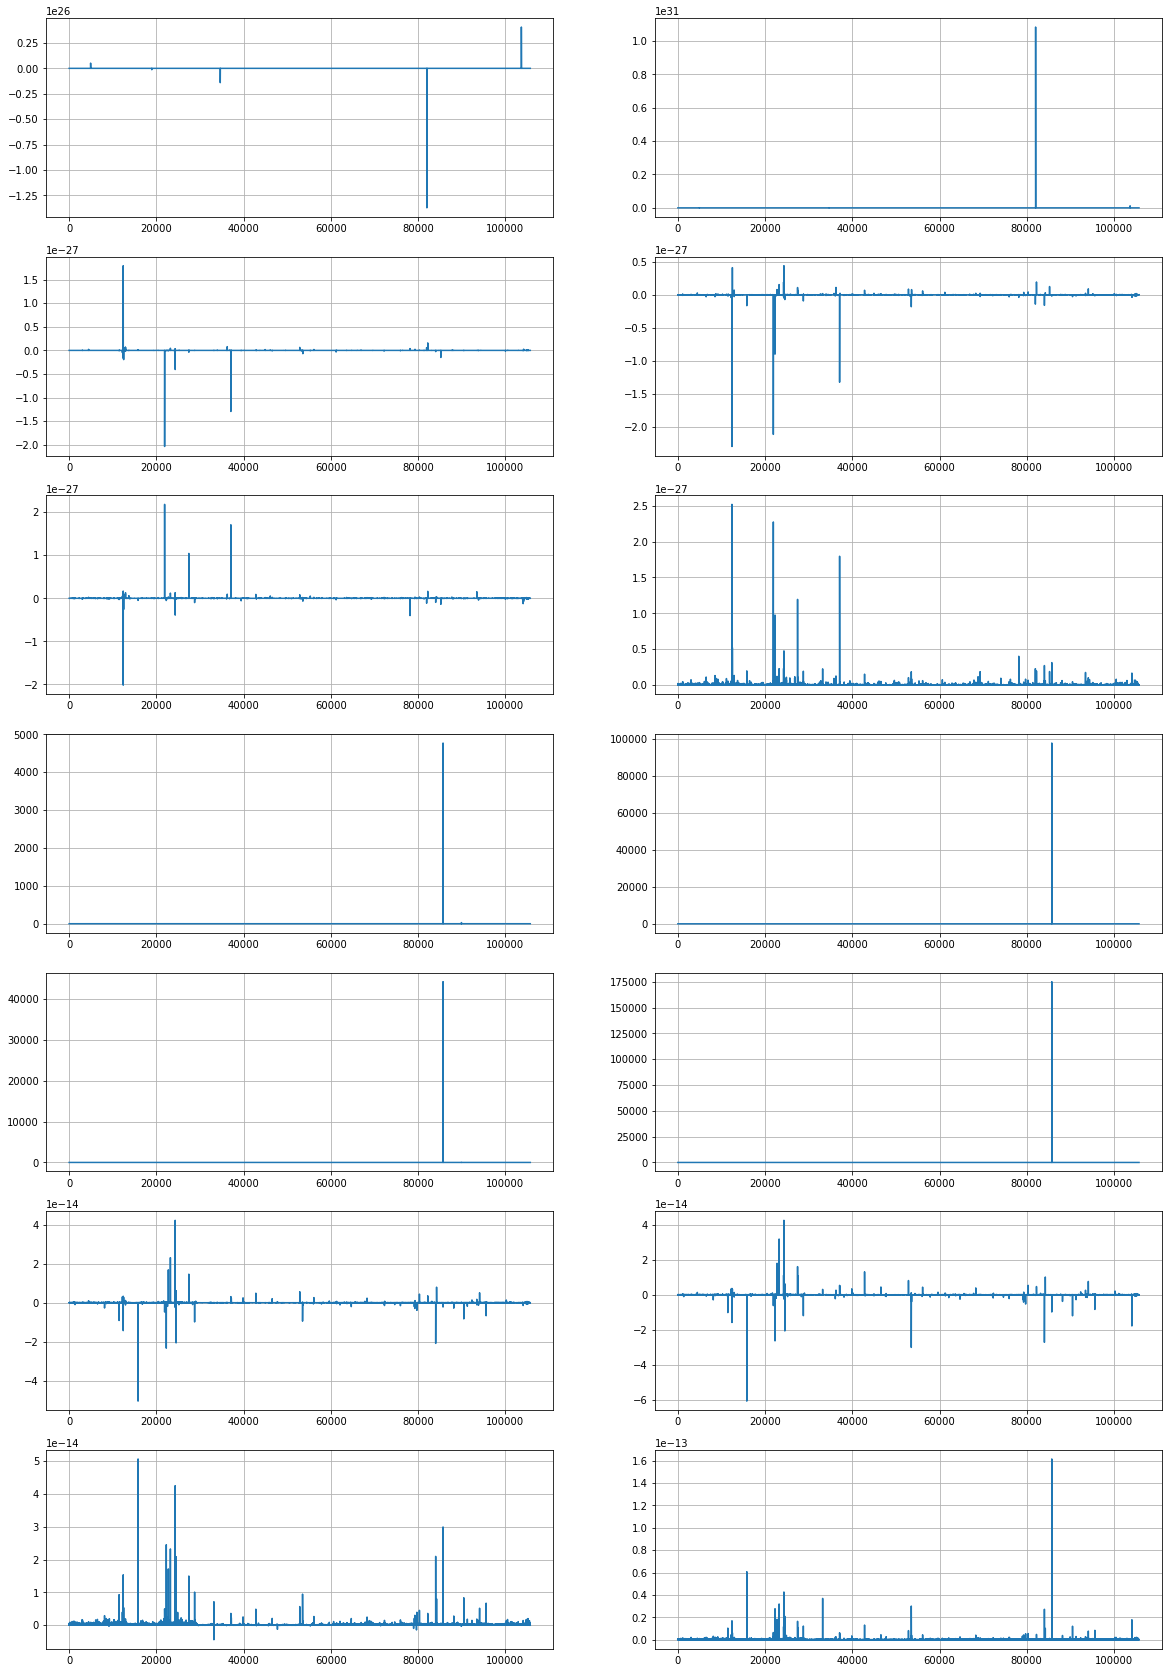

In [3]:
fig, axes = plt.subplots(7,2,figsize=(20,30))
k = 0
l = 0
for i in range(1,15): 
    pos = i
    x_plot = np.linspace(0,len(x),len(x))
    axes[l,k].plot(x_plot, x[:,pos])
    axes[l,k].grid()
    k += 1
    if k!=0 and k%2==0:
        l += 1
        k  = 0

So, we clean the data above a certain threshold

In [42]:
'''Cleaning Data'''

threshold = [60000, 1*10**7, 1*10**7, 0.5*10**(-28), 0.5*10**(-28), 
1*10**(-28), 2*10**(-28), 
20,20,20,100,
             0.5*10**(-13),0.5*10**(-13),1*10**(-13), 1*10**(-13)]

for i in range(15):
    idx = np.argwhere((x[:,i] >= threshold[i]) | (x[:,i] <= -threshold[i]))
    x = np.delete(x, idx,0)
    y = np.delete(y, idx)
print("X shape after truncation: ", x.shape) 
print("y shape after truncation: ",y.shape) 

X shape after truncation:  (105691, 15)
y shape after truncation:  (105691,)


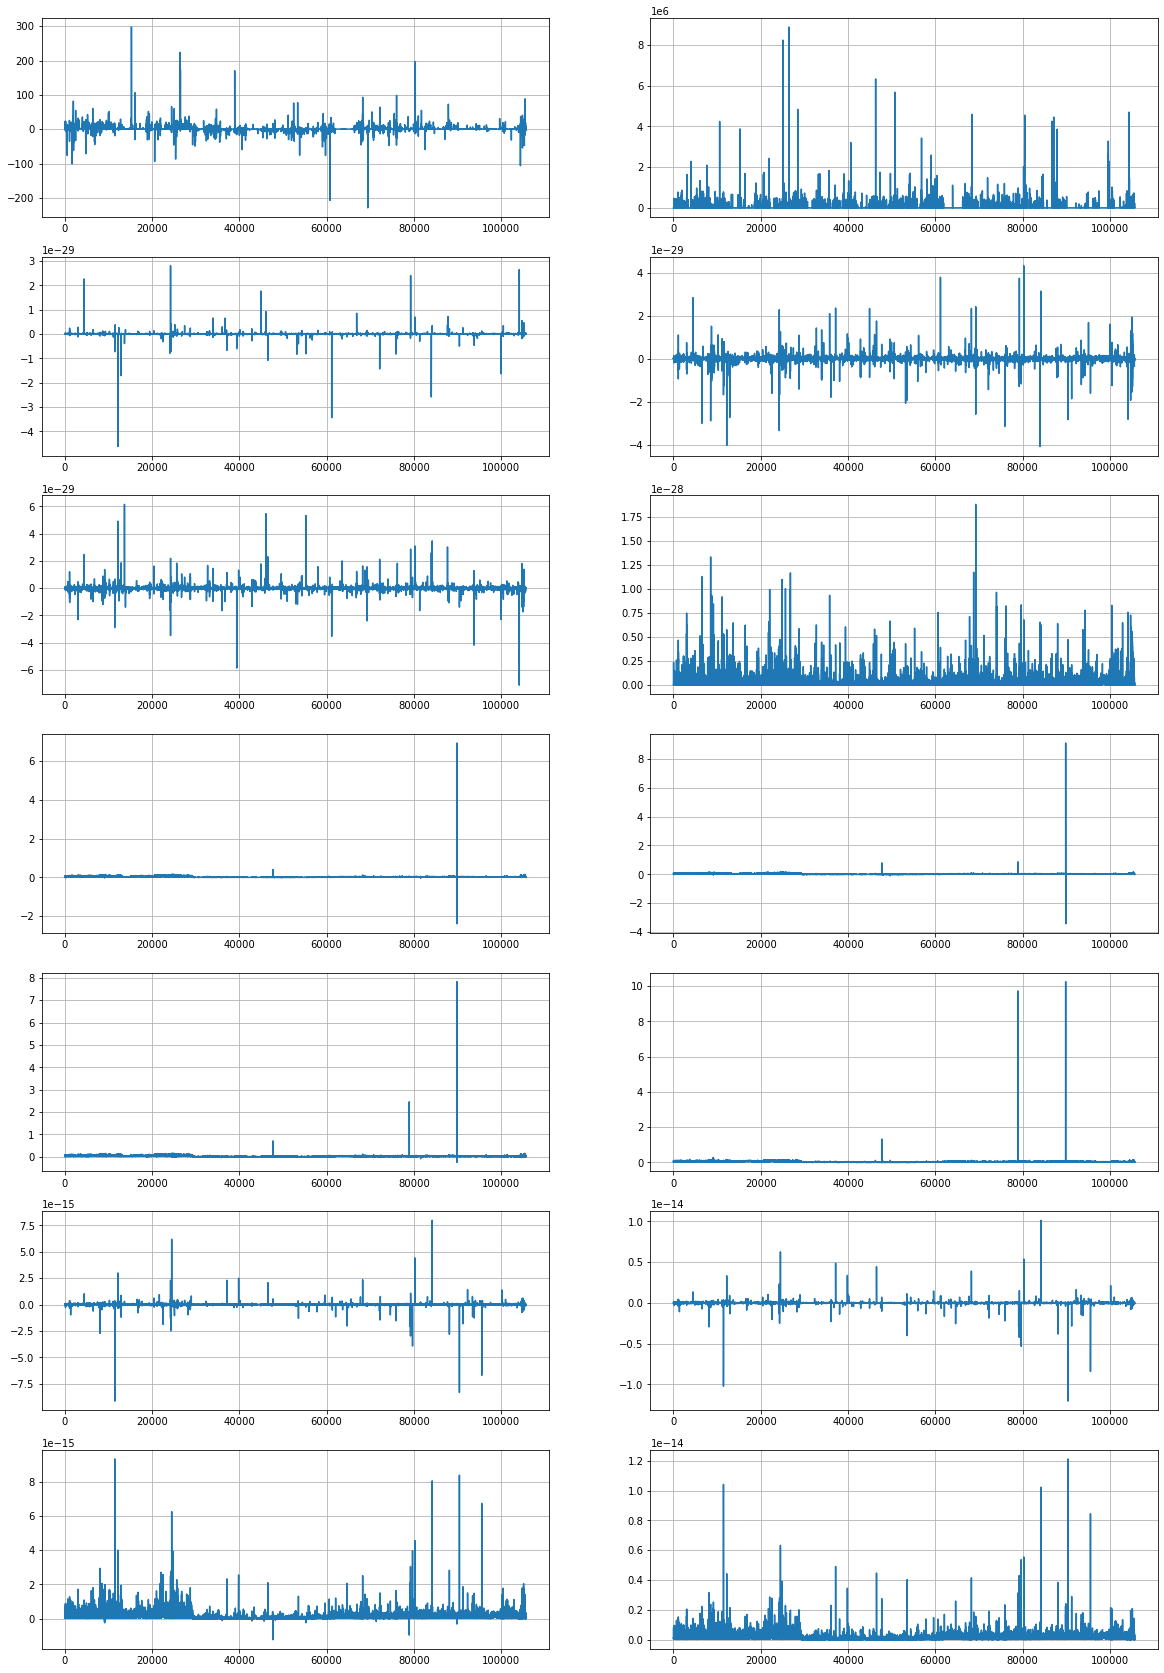

In [5]:
fig, axes = plt.subplots(7,2,figsize=(20,30))
k = 0
l = 0
for i in range(1,15):
    pos = i
    x_plot = np.linspace(0,len(x),len(x))
    axes[l,k].plot(x_plot, x[:,pos])
    axes[l,k].grid()
    k += 1
    if k!=0 and k%2==0:
        l += 1
        k  = 0

In [6]:
y_true = np.zeros(y.shape,dtype=int)
y = y[y != 'nan']
print(y[-1]) 
for i in range(len(y)):

    g = y[i].split('.')
    g = g[0] + g[1]
    y_true[i] = int(g)


6.20.90.30


In [7]:
'''Divide labels in 5 Classes'''

flag = 0 
c1 = 0
c2 = 0
c3 = 0
c4 = 0
c6 = 0
for i in range(len(y)):
    if(y[i][0]=='1'):
        c1 += 1
    elif(y[i][0]=='2'):
        c2 += 1
    elif(y[i][0]=='3'):
        c3 += 1 
    elif(y[i][0]=='4'):
        c4 += 1
    else:
        c6 += 1

print(f"The '1' class is long : {c1}")
print(f"The '2' class is long : {c2}")
print(f"The '3' class is long : {c3}")
print(f"The '4' class is long : {c4}")
print(f"The '6' class is long : {c6}")

#index
c1 = c1
c2 = c2 + c1
c3 = c3 + c2
c4 = c4 + c3
c6 = c6 + c4

The '1' class is long : 29295
The '2' class is long : 27989
The '3' class is long : 47134
The '4' class is long : 798
The '6' class is long : 475


In [8]:
# print(f"The '1' class is long : {c1}")
# print(f"The '2' class is long : {c2}")
# print(f"The '3' class is long : {c3}")
# print(f"The '4' class is long : {c4}")
# print(f"The '6' class is long : {c6}")

In [9]:
x_1 = x[:c3,:]
print(x_1.shape)
y_1 = y[:c3]
print(y_1)


(104418, 15)
['1.10.10.10' '1.10.10.10' '1.10.10.10' ... '3.90.960.10' '3.90.960.10'
 '3.90.980.20']


In [10]:
y_label = np.zeros((c3,1))
y_label[:c1] = 0
y_label[c1:c2] = 1
y_label[c2:] = 2

In [11]:
'''Scaling data'''

x_standard = StandardScaler().fit_transform(x_1)
y_label = np.ravel(y_label)

In [12]:
y_label_2 = np.zeros((len(y_label), 3))
print(y_label_2.shape)
for i in range(len(y_label)):
    if y_label[i] == 0:
        y_label_2[i,0] = 1
        
    if y_label[i] == 1:
        y_label_2[i,1] = 1
        
    if y_label[i] == 2:
        y_label_2[i,2] = 1

y_label = y_label_2

(104418, 3)


In [13]:
x_standard = StandardScaler().fit_transform(x_1)
#y_label = np.ravel(y_label)
print(x_standard.shape)
print(y_label.shape)

(104418, 15)
(104418, 3)


In order to classify the protein in the class **C**, we build a NN with a input layer of $15$ neurons and a output layer of $3$ neurons, since **C** $= 0,1,2$.

For the hyperparameters of the model, we use the results of a GridSearch. In particoular:

- Optimizer = `Adam`
- Activation function = `relu`
- Number of Epochs $= 300$
- Batch Size $= 70$
- Dropout Rate $= 0.2$

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x_standard, y_label, train_size=0.8, random_state = 123)

In [15]:
def create_model(activation='relu',optimizer='adam',dropout_rate=0.2, L = 15):
# create model
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = activation))
    model.add(Dense(150,activation = activation))

    model.add(Dropout(dropout_rate))
    model.add(Dense(100,activation = activation))
    model.add(Dense(70,activation = activation))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(30,activation = activation))
    model.add(Dense(3, activation = 'softmax'))
    print(model.summary())

# compile model
    model.compile( loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model
model = create_model()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 150)               2400      
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_3 (Dense)              (None, 70)                7070      
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                2

In [16]:
fit = model.fit(X_train, y_train,
               epochs = 300, batch_size = 70,
               validation_data = (X_test,y_test),
               shuffle = True) #after one epochs it shuffle the order of data

Train on 83534 samples, validate on 20884 samples
Epoch 1/300
83534/83534 [==============================] - 4s 50us/sample - loss: 0.5383 - accuracy: 0.7799 - val_loss: 0.4579 - val_accuracy: 0.8013
Epoch 2/300
83534/83534 [==============================] - 3s 37us/sample - loss: 0.4796 - accuracy: 0.8023 - val_loss: 0.4281 - val_accuracy: 0.8206
Epoch 3/300
83534/83534 [==============================] - 4s 44us/sample - loss: 0.4486 - accuracy: 0.8163 - val_loss: 0.4208 - val_accuracy: 0.8284
Epoch 4/300
83534/83534 [==============================] - 4s 43us/sample - loss: 0.4244 - accuracy: 0.8269 - val_loss: 0.4209 - val_accuracy: 0.8203
Epoch 5/300
83534/83534 [==============================] - 3s 39us/sample - loss: 0.4076 - accuracy: 0.8329 - val_loss: 0.3814 - val_accuracy: 0.8432
Epoch 6/300
83534/83534 [==============================] - 3s 37us/sample - loss: 0.3931 - accuracy: 0.8388 - val_loss: 0.3721 - val_accuracy: 0.8484
Epoch 7/300
83534/83534 [=========================

Epoch 55/300
83534/83534 [==============================] - 3s 39us/sample - loss: 0.2703 - accuracy: 0.8929 - val_loss: 0.2535 - val_accuracy: 0.8995
Epoch 56/300
83534/83534 [==============================] - 3s 39us/sample - loss: 0.2665 - accuracy: 0.8943 - val_loss: 0.2540 - val_accuracy: 0.9017
Epoch 57/300
83534/83534 [==============================] - 3s 39us/sample - loss: 0.2653 - accuracy: 0.8954 - val_loss: 0.2546 - val_accuracy: 0.9002
Epoch 58/300
83534/83534 [==============================] - 3s 40us/sample - loss: 0.2657 - accuracy: 0.8961 - val_loss: 0.2513 - val_accuracy: 0.9021
Epoch 59/300
83534/83534 [==============================] - 3s 39us/sample - loss: 0.2633 - accuracy: 0.8957 - val_loss: 0.2514 - val_accuracy: 0.9012
Epoch 60/300
83534/83534 [==============================] - 3s 38us/sample - loss: 0.2627 - accuracy: 0.8949 - val_loss: 0.2517 - val_accuracy: 0.9042
Epoch 61/300
83534/83534 [==============================] - 3s 39us/sample - loss: 0.2623 - ac

83534/83534 [==============================] - 3s 40us/sample - loss: 0.2367 - accuracy: 0.9083 - val_loss: 0.2325 - val_accuracy: 0.9111
Epoch 110/300
83534/83534 [==============================] - 3s 39us/sample - loss: 0.2366 - accuracy: 0.9071 - val_loss: 0.2345 - val_accuracy: 0.9143
Epoch 111/300
83534/83534 [==============================] - 3s 40us/sample - loss: 0.2352 - accuracy: 0.9071 - val_loss: 0.2317 - val_accuracy: 0.9114
Epoch 112/300
83534/83534 [==============================] - 3s 38us/sample - loss: 0.2361 - accuracy: 0.9067 - val_loss: 0.2334 - val_accuracy: 0.9097
Epoch 113/300
83534/83534 [==============================] - 3s 39us/sample - loss: 0.2351 - accuracy: 0.9077 - val_loss: 0.2290 - val_accuracy: 0.9157
Epoch 114/300
83534/83534 [==============================] - 3s 38us/sample - loss: 0.2330 - accuracy: 0.9083 - val_loss: 0.2386 - val_accuracy: 0.9123
Epoch 115/300
83534/83534 [==============================] - 3s 38us/sample - loss: 0.2368 - accuracy:

Epoch 163/300
83534/83534 [==============================] - 3s 37us/sample - loss: 0.2204 - accuracy: 0.9147 - val_loss: 0.2143 - val_accuracy: 0.9211
Epoch 164/300
83534/83534 [==============================] - 3s 36us/sample - loss: 0.2190 - accuracy: 0.9148 - val_loss: 0.2196 - val_accuracy: 0.9178
Epoch 165/300
83534/83534 [==============================] - 3s 37us/sample - loss: 0.2210 - accuracy: 0.9144 - val_loss: 0.2188 - val_accuracy: 0.9193
Epoch 166/300
83534/83534 [==============================] - 3s 36us/sample - loss: 0.2187 - accuracy: 0.9145 - val_loss: 0.2184 - val_accuracy: 0.9182
Epoch 167/300
83534/83534 [==============================] - 3s 37us/sample - loss: 0.2215 - accuracy: 0.9150 - val_loss: 0.2151 - val_accuracy: 0.9198
Epoch 168/300
83534/83534 [==============================] - 3s 36us/sample - loss: 0.2191 - accuracy: 0.9151 - val_loss: 0.2152 - val_accuracy: 0.9200
Epoch 169/300
83534/83534 [==============================] - 3s 36us/sample - loss: 0.22

Epoch 217/300
83534/83534 [==============================] - 3s 40us/sample - loss: 0.2097 - accuracy: 0.9180 - val_loss: 0.2153 - val_accuracy: 0.9206
Epoch 218/300
83534/83534 [==============================] - 3s 38us/sample - loss: 0.2089 - accuracy: 0.9184 - val_loss: 0.2147 - val_accuracy: 0.9211
Epoch 219/300
83534/83534 [==============================] - 3s 38us/sample - loss: 0.2107 - accuracy: 0.9193 - val_loss: 0.2123 - val_accuracy: 0.9220
Epoch 220/300
83534/83534 [==============================] - 3s 37us/sample - loss: 0.2123 - accuracy: 0.9173 - val_loss: 0.2160 - val_accuracy: 0.9217
Epoch 221/300
83534/83534 [==============================] - 3s 37us/sample - loss: 0.2088 - accuracy: 0.9181 - val_loss: 0.2175 - val_accuracy: 0.9230
Epoch 222/300
83534/83534 [==============================] - 3s 37us/sample - loss: 0.2094 - accuracy: 0.9185 - val_loss: 0.2124 - val_accuracy: 0.9227
Epoch 223/300
83534/83534 [==============================] - 3s 37us/sample - loss: 0.21

Epoch 271/300
83534/83534 [==============================] - 4s 49us/sample - loss: 0.2016 - accuracy: 0.9220 - val_loss: 0.2047 - val_accuracy: 0.9246
Epoch 272/300
83534/83534 [==============================] - 4s 43us/sample - loss: 0.2022 - accuracy: 0.9219 - val_loss: 0.2091 - val_accuracy: 0.9263
Epoch 273/300
83534/83534 [==============================] - 3s 40us/sample - loss: 0.2025 - accuracy: 0.9223 - val_loss: 0.2058 - val_accuracy: 0.9255
Epoch 274/300
83534/83534 [==============================] - 3s 39us/sample - loss: 0.2011 - accuracy: 0.9221 - val_loss: 0.2072 - val_accuracy: 0.9248
Epoch 275/300
83534/83534 [==============================] - 4s 46us/sample - loss: 0.2045 - accuracy: 0.9211 - val_loss: 0.2138 - val_accuracy: 0.9246
Epoch 276/300
83534/83534 [==============================] - 4s 42us/sample - loss: 0.2033 - accuracy: 0.9222 - val_loss: 0.2076 - val_accuracy: 0.9239
Epoch 277/300
83534/83534 [==============================] - 3s 41us/sample - loss: 0.20

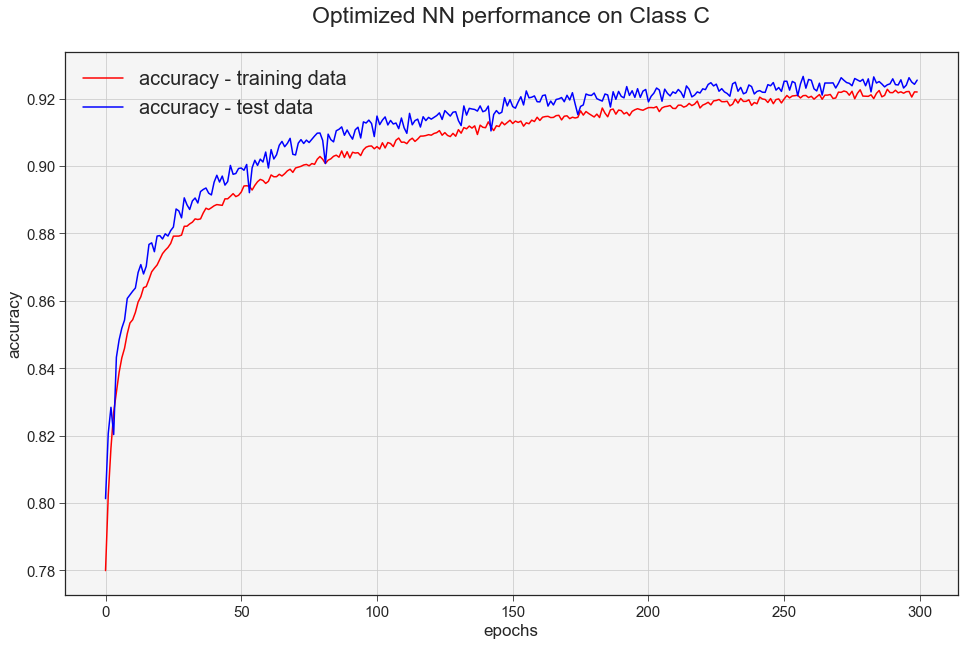

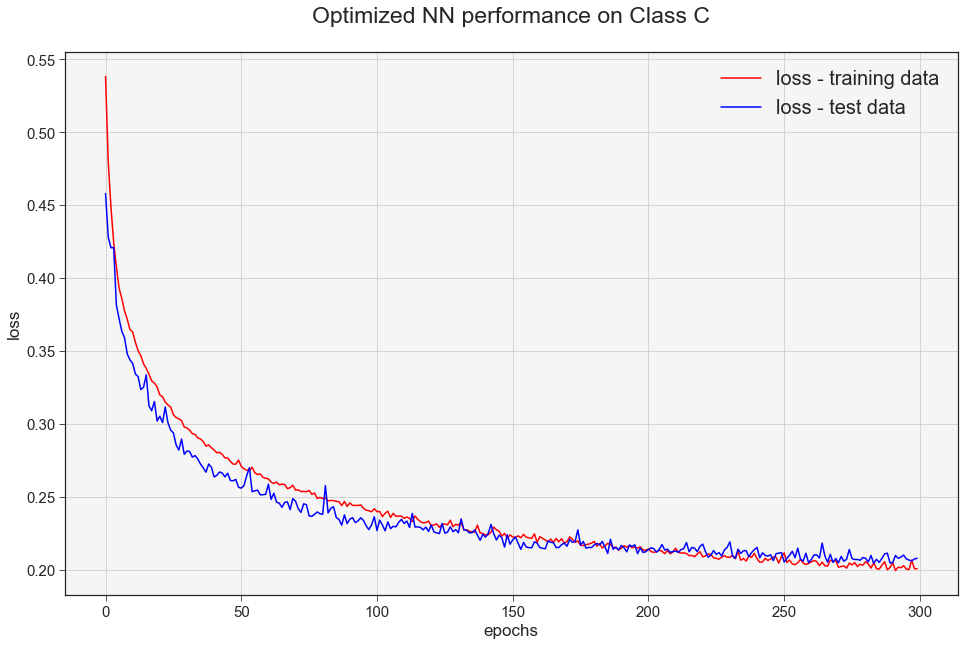

In [17]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(16,10))
    plt.style.use('seaborn-ticks')
    plt.plot(fit.history[obs], 'r', label = obs +' - training data')
    plt.plot(fit.history['val_' + obs], 'b', label = obs + ' - test data')
    plt.title('Optimized NN performance on Class C\n', fontsize = 23)
    ax = plt.subplot()
    ax.set_facecolor("whitesmoke")
    plt.xlabel('epochs', fontsize = 17)
    plt.ylabel(obs, fontsize = 17)
    plt.legend(loc = "best", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.grid()
    plt.show()

## Classification for class A ($\alpha$ helix)

In [18]:
x_1 = x[:c1,:]
print("Number of protein in C=0: ", x_1.shape)
y_1 = y_true[:c1]
uniqs, counts = np.unique(y_1,return_counts= True)
print("labels in class A: ", uniqs)
print("Number of proteins in each label: ", counts)

Number of protein in C=0:  (29295, 15)
labels in class A:  [110 120 125 140 150]
Number of proteins in each label:  [19969  7954  1042     5   325]


There are $29295$ $\alpha$ helix proteins, (Class **C** $=1$), for which we have $5$ labels in class **A**. 


In [19]:
uniqs = np.unique(y_1)
y_label = np.zeros((len(y_1), len(uniqs)))
print(y_label.shape)

j = 0
for uniq in uniqs:
    for i in range(len(y_1)):
        if y_1[i] == uniq:
            y_label[i,j] = 1
    j+=1

(29295, 5)


In [20]:
x_standard = StandardScaler().fit_transform(x_1)
print(x_standard.shape)
print(y_label.shape)

(29295, 15)
(29295, 5)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(x_standard, y_label, train_size=0.8, random_state = 123)

The architecture of the model is similar to the previous one, but here we have about $30000$ samples. 

So we reduce the number of neurons in the hidden layers.

In [22]:
def create_model_2(activation='relu',optimizer='adam',dropout_rate=0.2, L = 15):
# create model
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = activation))
    model.add(Dense(100,activation = activation))
    
    model.add(Dropout(dropout_rate))
    #model.add(Dense(150,activation = activation))
    model.add(Dense(70,activation = activation))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(30,activation = activation))
    model.add(Dense(5, activation = 'softmax'))
    print(model.summary())

# compile model
    model.compile( loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model
model_2 = create_model_2()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 70)                7070      
_________________________________________________________________
dropout_3 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 30)                2130      
_________________________________________________________________
dense_10 (Dense)             (None, 5)                

In [23]:
fit = model_2.fit(X_train, y_train,
               epochs = 300, batch_size = 50,
               validation_data = (X_test,y_test),
               shuffle = True) #after one epochs it shuffle the order of data

Train on 23436 samples, validate on 5859 samples
Epoch 1/300
23436/23436 [==============================] - 2s 77us/sample - loss: 0.7907 - accuracy: 0.6991 - val_loss: 0.7159 - val_accuracy: 0.7117
Epoch 2/300
23436/23436 [==============================] - 1s 52us/sample - loss: 0.7152 - accuracy: 0.7113 - val_loss: 0.7170 - val_accuracy: 0.6899
Epoch 3/300
23436/23436 [==============================] - 1s 58us/sample - loss: 0.6958 - accuracy: 0.7115 - val_loss: 0.6831 - val_accuracy: 0.7098
Epoch 4/300
23436/23436 [==============================] - 1s 56us/sample - loss: 0.6755 - accuracy: 0.7170 - val_loss: 0.6797 - val_accuracy: 0.7104
Epoch 5/300
23436/23436 [==============================] - 1s 55us/sample - loss: 0.6660 - accuracy: 0.7185 - val_loss: 0.6529 - val_accuracy: 0.7153
Epoch 6/300
23436/23436 [==============================] - 1s 54us/sample - loss: 0.6483 - accuracy: 0.7227 - val_loss: 0.6443 - val_accuracy: 0.7170
Epoch 7/300
23436/23436 [==========================

Epoch 55/300
23436/23436 [==============================] - 1s 55us/sample - loss: 0.4464 - accuracy: 0.8238 - val_loss: 0.4464 - val_accuracy: 0.8257
Epoch 56/300
23436/23436 [==============================] - 1s 55us/sample - loss: 0.4441 - accuracy: 0.8277 - val_loss: 0.4394 - val_accuracy: 0.8259
Epoch 57/300
23436/23436 [==============================] - 1s 54us/sample - loss: 0.4429 - accuracy: 0.8254 - val_loss: 0.4367 - val_accuracy: 0.8329
Epoch 58/300
23436/23436 [==============================] - 1s 53us/sample - loss: 0.4391 - accuracy: 0.8285 - val_loss: 0.4423 - val_accuracy: 0.8297
Epoch 59/300
23436/23436 [==============================] - 1s 55us/sample - loss: 0.4376 - accuracy: 0.8300 - val_loss: 0.4445 - val_accuracy: 0.8266
Epoch 60/300
23436/23436 [==============================] - 1s 51us/sample - loss: 0.4410 - accuracy: 0.8271 - val_loss: 0.4374 - val_accuracy: 0.8315
Epoch 61/300
23436/23436 [==============================] - 1s 53us/sample - loss: 0.4388 - ac

23436/23436 [==============================] - 1s 52us/sample - loss: 0.3943 - accuracy: 0.8492 - val_loss: 0.3988 - val_accuracy: 0.8496
Epoch 110/300
23436/23436 [==============================] - 1s 54us/sample - loss: 0.3924 - accuracy: 0.8483 - val_loss: 0.3879 - val_accuracy: 0.8500
Epoch 111/300
23436/23436 [==============================] - 1s 55us/sample - loss: 0.3880 - accuracy: 0.8489 - val_loss: 0.3902 - val_accuracy: 0.8520
Epoch 112/300
23436/23436 [==============================] - 1s 53us/sample - loss: 0.3915 - accuracy: 0.8484 - val_loss: 0.3892 - val_accuracy: 0.8515
Epoch 113/300
23436/23436 [==============================] - 1s 54us/sample - loss: 0.3903 - accuracy: 0.8469 - val_loss: 0.3880 - val_accuracy: 0.8551
Epoch 114/300
23436/23436 [==============================] - 1s 52us/sample - loss: 0.3883 - accuracy: 0.8496 - val_loss: 0.3902 - val_accuracy: 0.8542
Epoch 115/300
23436/23436 [==============================] - 1s 52us/sample - loss: 0.3897 - accuracy:

Epoch 163/300
23436/23436 [==============================] - 1s 52us/sample - loss: 0.3696 - accuracy: 0.8563 - val_loss: 0.3709 - val_accuracy: 0.8609
Epoch 164/300
23436/23436 [==============================] - 1s 54us/sample - loss: 0.3674 - accuracy: 0.8556 - val_loss: 0.3732 - val_accuracy: 0.8602
Epoch 165/300
23436/23436 [==============================] - 1s 53us/sample - loss: 0.3675 - accuracy: 0.8561 - val_loss: 0.3790 - val_accuracy: 0.8568
Epoch 166/300
23436/23436 [==============================] - 1s 53us/sample - loss: 0.3675 - accuracy: 0.8566 - val_loss: 0.3770 - val_accuracy: 0.8578
Epoch 167/300
23436/23436 [==============================] - 1s 54us/sample - loss: 0.3666 - accuracy: 0.8592 - val_loss: 0.3760 - val_accuracy: 0.8578
Epoch 168/300
23436/23436 [==============================] - 1s 55us/sample - loss: 0.3592 - accuracy: 0.8591 - val_loss: 0.3639 - val_accuracy: 0.8614
Epoch 169/300
23436/23436 [==============================] - 1s 53us/sample - loss: 0.36

Epoch 217/300
23436/23436 [==============================] - 1s 53us/sample - loss: 0.3483 - accuracy: 0.8634 - val_loss: 0.3579 - val_accuracy: 0.8684
Epoch 218/300
23436/23436 [==============================] - 1s 52us/sample - loss: 0.3505 - accuracy: 0.8658 - val_loss: 0.3626 - val_accuracy: 0.8619
Epoch 219/300
23436/23436 [==============================] - 1s 53us/sample - loss: 0.3442 - accuracy: 0.8663 - val_loss: 0.3538 - val_accuracy: 0.8658
Epoch 220/300
23436/23436 [==============================] - 1s 52us/sample - loss: 0.3535 - accuracy: 0.8618 - val_loss: 0.3597 - val_accuracy: 0.8638
Epoch 221/300
23436/23436 [==============================] - 1s 53us/sample - loss: 0.3473 - accuracy: 0.8657 - val_loss: 0.3721 - val_accuracy: 0.8629
Epoch 222/300
23436/23436 [==============================] - 1s 52us/sample - loss: 0.3497 - accuracy: 0.8643 - val_loss: 0.3540 - val_accuracy: 0.8679
Epoch 223/300
23436/23436 [==============================] - 1s 53us/sample - loss: 0.35

Epoch 271/300
23436/23436 [==============================] - 1s 56us/sample - loss: 0.3403 - accuracy: 0.8686 - val_loss: 0.3506 - val_accuracy: 0.8681
Epoch 272/300
23436/23436 [==============================] - 1s 57us/sample - loss: 0.3382 - accuracy: 0.8668 - val_loss: 0.3423 - val_accuracy: 0.8749
Epoch 273/300
23436/23436 [==============================] - 1s 55us/sample - loss: 0.3433 - accuracy: 0.8702 - val_loss: 0.3630 - val_accuracy: 0.8643
Epoch 274/300
23436/23436 [==============================] - 1s 54us/sample - loss: 0.3352 - accuracy: 0.8695 - val_loss: 0.3513 - val_accuracy: 0.8684
Epoch 275/300
23436/23436 [==============================] - 1s 53us/sample - loss: 0.3391 - accuracy: 0.8674 - val_loss: 0.3456 - val_accuracy: 0.8696
Epoch 276/300
23436/23436 [==============================] - 1s 55us/sample - loss: 0.3351 - accuracy: 0.8699 - val_loss: 0.3594 - val_accuracy: 0.8669
Epoch 277/300
23436/23436 [==============================] - 1s 54us/sample - loss: 0.33

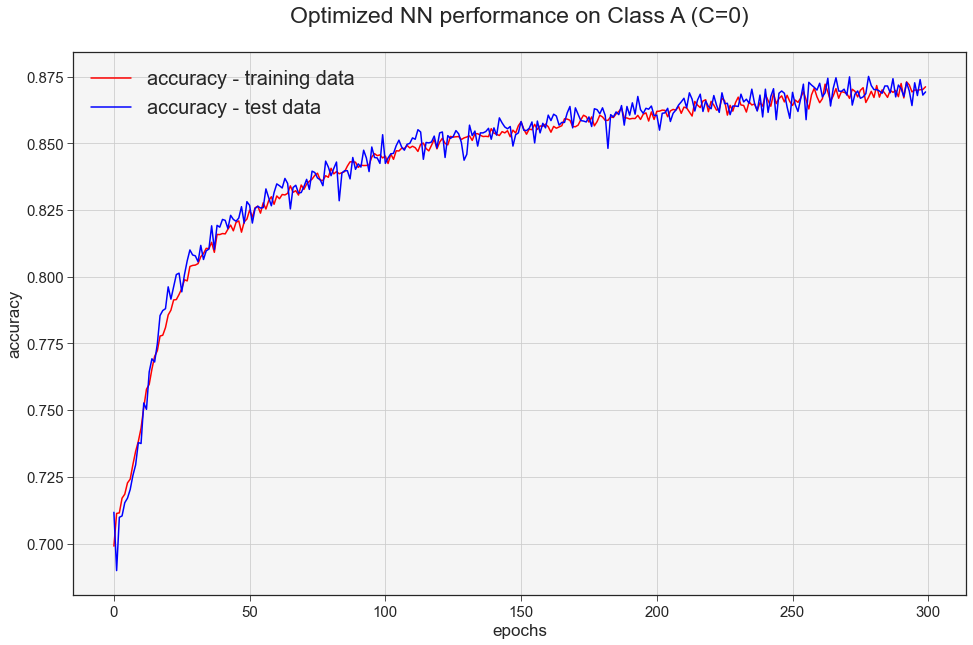

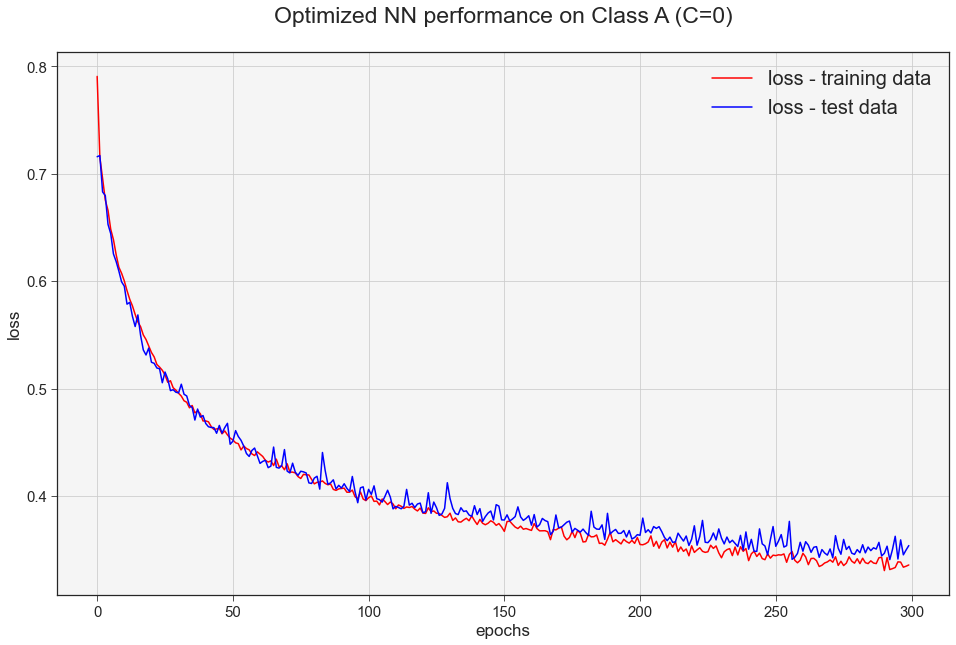

In [24]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(16,10))
    plt.style.use('seaborn-ticks')
    plt.plot(fit.history[obs], 'r', label = obs +' - training data')
    plt.plot(fit.history['val_' + obs], 'b', label = obs + ' - test data')
    plt.title('Optimized NN performance on Class A (C=0)\n', fontsize = 23)
    ax = plt.subplot()
    ax.set_facecolor("whitesmoke")
    plt.xlabel('epochs', fontsize = 17)
    plt.ylabel(obs, fontsize = 17)
    plt.legend(loc = "best", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.grid()
    plt.show()

## Classification for class A ($\beta$ sheet)

In [25]:
x_1 = x[c1:c2,:]
print(x_1.shape)
y_1 = y_true[c1:c2]
print(y_1.shape)

(27989, 15)
(27989,)


There are $27989$ $\beta$ sheet proteins, (Class **C** $=2$), for which we have $20$ labels in class **A**. But under some labels there are very few elements, so we neglict those categories.

We end up with $27507$ and $11$ labels.

In [26]:
uniqs, counts = np.unique(y_1,return_counts= True)
print("Labels in class A: ", uniqs,"\n")
print("Number of proteins in each label: ", counts)

Labels in class A:  [ 210  220  230  240  250  260  270  280  290 2100 2102 2110 2115 2120
 2130 2140 2150 2160 2170 2180] 

Number of proteins in each label:  [ 1240   490  2827  7116    32 12918  1032   433    48   101    68    17
    70   341   368   129    15   350   392     2]


In [27]:
cancel = [2180, 2150, 2140, 2115, 2110, 2102, 2100, 290, 250]
cancel.sort()

i_idx = []
for can in cancel:
    for i in range(len(y_1)):
        if y_1[i] == can:
            i_idx.append(i)
y_1 = np.delete(y_1, i_idx)
x_1 = np.delete(x_1, i_idx,0)

In [28]:
uniqs = np.unique(y_1)
y_label = np.zeros((len(y_1), len(uniqs)))
print(y_label.shape)

j = 0
for uniq in uniqs:
    for i in range(len(y_1)):
        if y_1[i] == uniq:
            y_label[i,j] = 1
    j+=1

(27507, 11)


In [29]:
x_standard = StandardScaler().fit_transform(x_1)
#y_label = np.ravel(y_label)
print(x_standard.shape)
print(y_label.shape)

(27507, 15)
(27507, 11)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(x_standard, y_label, train_size=0.8, random_state = 123)

In [31]:

def create_model_3(activation='relu',optimizer='adam',dropout_rate=0.1, L = 15):
# create model
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = activation))
    model.add(Dense(50,activation = activation))
    
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(100,activation = activation))
    model.add(Dense(50,activation = activation))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(30,activation = activation))
    model.add(Dense(11, activation = 'softmax'))
    print(model.summary())

# compile model
    model.compile( loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model
model_3 = create_model_3()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_12 (Dense)             (None, 50)                800       
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 30)               

In [32]:
fit = model_3.fit(X_train, y_train,
               epochs = 300, batch_size = 50,
               validation_data = (X_test,y_test),
               shuffle = True) #after one epochs it shuffle the order of data

Train on 22005 samples, validate on 5502 samples
Epoch 1/300
22005/22005 [==============================] - 2s 86us/sample - loss: 1.5318 - accuracy: 0.4943 - val_loss: 1.3822 - val_accuracy: 0.5214
Epoch 2/300
22005/22005 [==============================] - 1s 61us/sample - loss: 1.3306 - accuracy: 0.5394 - val_loss: 1.2869 - val_accuracy: 0.5344
Epoch 3/300
22005/22005 [==============================] - 1s 67us/sample - loss: 1.2458 - accuracy: 0.5588 - val_loss: 1.2071 - val_accuracy: 0.5663
Epoch 4/300
22005/22005 [==============================] - 1s 63us/sample - loss: 1.1829 - accuracy: 0.5796 - val_loss: 1.1522 - val_accuracy: 0.5952
Epoch 5/300
22005/22005 [==============================] - 1s 58us/sample - loss: 1.1358 - accuracy: 0.5970 - val_loss: 1.0983 - val_accuracy: 0.5981
Epoch 6/300
22005/22005 [==============================] - 1s 58us/sample - loss: 1.0909 - accuracy: 0.6116 - val_loss: 1.0575 - val_accuracy: 0.6129
Epoch 7/300
22005/22005 [==========================

Epoch 55/300
22005/22005 [==============================] - 1s 56us/sample - loss: 0.5927 - accuracy: 0.7872 - val_loss: 0.5829 - val_accuracy: 0.7955
Epoch 56/300
22005/22005 [==============================] - 1s 56us/sample - loss: 0.5901 - accuracy: 0.7892 - val_loss: 0.5646 - val_accuracy: 0.8068
Epoch 57/300
22005/22005 [==============================] - 1s 56us/sample - loss: 0.5873 - accuracy: 0.7901 - val_loss: 0.5700 - val_accuracy: 0.8033
Epoch 58/300
22005/22005 [==============================] - 1s 58us/sample - loss: 0.5756 - accuracy: 0.7951 - val_loss: 0.5758 - val_accuracy: 0.8030
Epoch 59/300
22005/22005 [==============================] - 1s 57us/sample - loss: 0.5855 - accuracy: 0.7915 - val_loss: 0.5763 - val_accuracy: 0.8044
Epoch 60/300
22005/22005 [==============================] - 1s 56us/sample - loss: 0.5751 - accuracy: 0.7942 - val_loss: 0.5614 - val_accuracy: 0.8066
Epoch 61/300
22005/22005 [==============================] - 1s 56us/sample - loss: 0.5708 - ac

22005/22005 [==============================] - 1s 58us/sample - loss: 0.4873 - accuracy: 0.8260 - val_loss: 0.4990 - val_accuracy: 0.8381
Epoch 110/300
22005/22005 [==============================] - 1s 58us/sample - loss: 0.4846 - accuracy: 0.8284 - val_loss: 0.4870 - val_accuracy: 0.8406
Epoch 111/300
22005/22005 [==============================] - 1s 57us/sample - loss: 0.4789 - accuracy: 0.8315 - val_loss: 0.4953 - val_accuracy: 0.8406
Epoch 112/300
22005/22005 [==============================] - 1s 59us/sample - loss: 0.4762 - accuracy: 0.8310 - val_loss: 0.4917 - val_accuracy: 0.8422
Epoch 113/300
22005/22005 [==============================] - 1s 57us/sample - loss: 0.4709 - accuracy: 0.8321 - val_loss: 0.4904 - val_accuracy: 0.8355
Epoch 114/300
22005/22005 [==============================] - 1s 56us/sample - loss: 0.4737 - accuracy: 0.8324 - val_loss: 0.4943 - val_accuracy: 0.8417
Epoch 115/300
22005/22005 [==============================] - 1s 58us/sample - loss: 0.4744 - accuracy:

Epoch 163/300
22005/22005 [==============================] - 1s 55us/sample - loss: 0.4334 - accuracy: 0.8434 - val_loss: 0.4642 - val_accuracy: 0.8501
Epoch 164/300
22005/22005 [==============================] - 1s 54us/sample - loss: 0.4395 - accuracy: 0.8468 - val_loss: 0.4552 - val_accuracy: 0.8530
Epoch 165/300
22005/22005 [==============================] - 1s 55us/sample - loss: 0.4302 - accuracy: 0.8480 - val_loss: 0.4627 - val_accuracy: 0.8473
Epoch 166/300
22005/22005 [==============================] - 1s 62us/sample - loss: 0.4390 - accuracy: 0.8456 - val_loss: 0.4625 - val_accuracy: 0.8515
Epoch 167/300
22005/22005 [==============================] - 1s 61us/sample - loss: 0.4333 - accuracy: 0.8461 - val_loss: 0.4719 - val_accuracy: 0.8462
Epoch 168/300
22005/22005 [==============================] - 1s 61us/sample - loss: 0.4327 - accuracy: 0.8452 - val_loss: 0.4696 - val_accuracy: 0.8481
Epoch 169/300
22005/22005 [==============================] - 1s 63us/sample - loss: 0.42

Epoch 217/300
22005/22005 [==============================] - 1s 56us/sample - loss: 0.4117 - accuracy: 0.8543 - val_loss: 0.4539 - val_accuracy: 0.8588
Epoch 218/300
22005/22005 [==============================] - 1s 56us/sample - loss: 0.4110 - accuracy: 0.8575 - val_loss: 0.4652 - val_accuracy: 0.8490
Epoch 219/300
22005/22005 [==============================] - 1s 57us/sample - loss: 0.4134 - accuracy: 0.8531 - val_loss: 0.4640 - val_accuracy: 0.8551
Epoch 220/300
22005/22005 [==============================] - 1s 60us/sample - loss: 0.4187 - accuracy: 0.8529 - val_loss: 0.4483 - val_accuracy: 0.8582
Epoch 221/300
22005/22005 [==============================] - 1s 57us/sample - loss: 0.4099 - accuracy: 0.8555 - val_loss: 0.4514 - val_accuracy: 0.8575
Epoch 222/300
22005/22005 [==============================] - 1s 57us/sample - loss: 0.4001 - accuracy: 0.8578 - val_loss: 0.4580 - val_accuracy: 0.8551
Epoch 223/300
22005/22005 [==============================] - 1s 57us/sample - loss: 0.40

Epoch 271/300
22005/22005 [==============================] - 1s 62us/sample - loss: 0.3969 - accuracy: 0.8586 - val_loss: 0.4544 - val_accuracy: 0.8557
Epoch 272/300
22005/22005 [==============================] - 1s 68us/sample - loss: 0.3867 - accuracy: 0.8631 - val_loss: 0.4405 - val_accuracy: 0.8628
Epoch 273/300
22005/22005 [==============================] - 1s 60us/sample - loss: 0.3944 - accuracy: 0.8627 - val_loss: 0.4503 - val_accuracy: 0.8615
Epoch 274/300
22005/22005 [==============================] - 1s 61us/sample - loss: 0.3914 - accuracy: 0.8633 - val_loss: 0.4521 - val_accuracy: 0.8595
Epoch 275/300
22005/22005 [==============================] - 1s 62us/sample - loss: 0.3907 - accuracy: 0.8599 - val_loss: 0.4596 - val_accuracy: 0.8593
Epoch 276/300
22005/22005 [==============================] - 1s 62us/sample - loss: 0.3928 - accuracy: 0.8605 - val_loss: 0.4476 - val_accuracy: 0.8595
Epoch 277/300
22005/22005 [==============================] - 2s 68us/sample - loss: 0.39

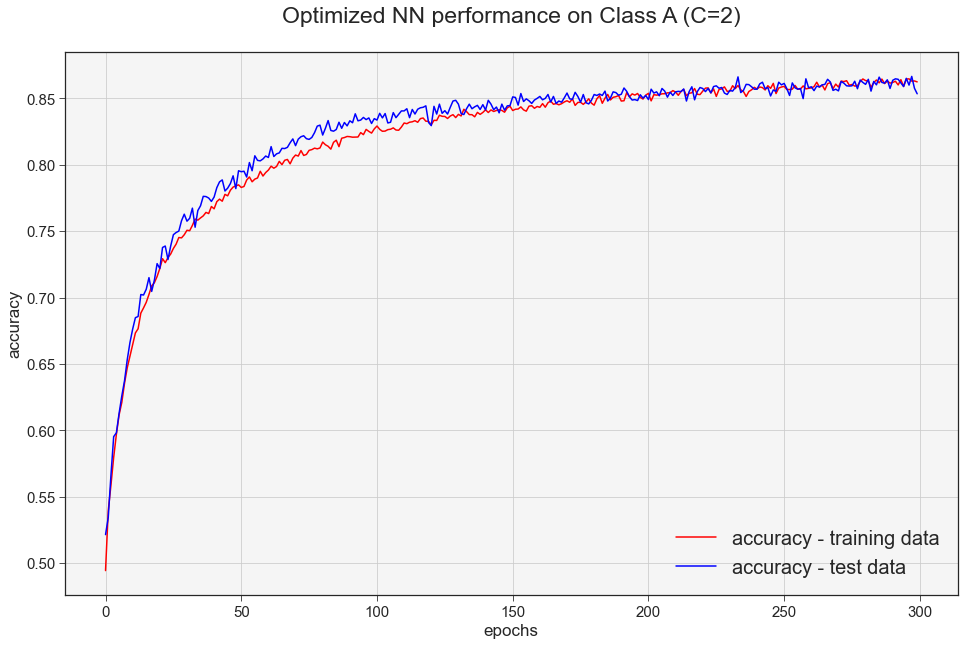

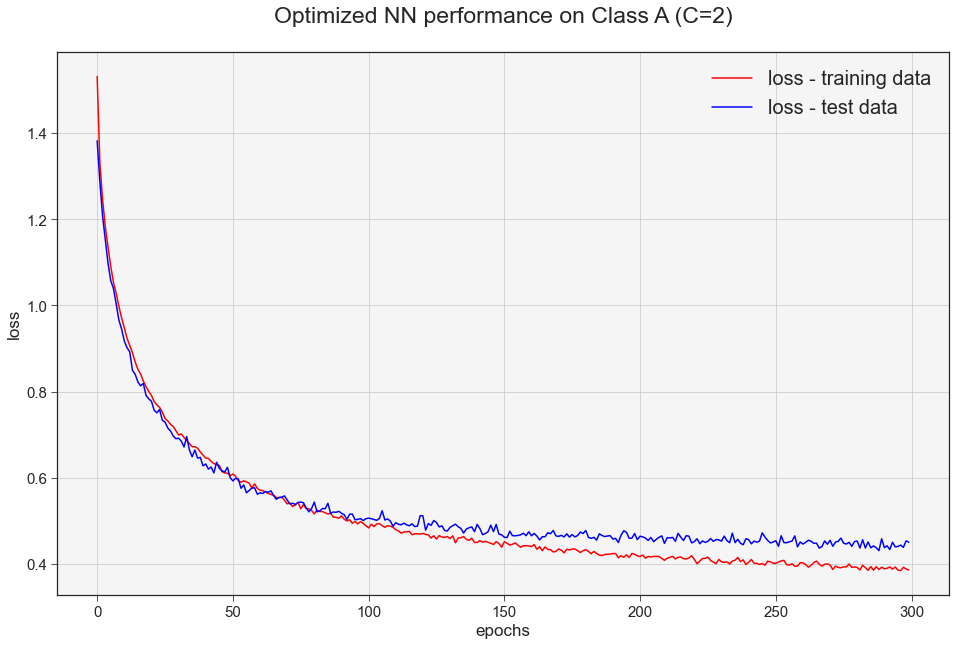

In [33]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(16,10))
    plt.style.use('seaborn-ticks')
    plt.plot(fit.history[obs], 'r', label = obs +' - training data')
    plt.plot(fit.history['val_' + obs], 'b', label = obs + ' - test data')
    plt.title('Optimized NN performance on Class A (C=2)\n', fontsize = 23)
    ax = plt.subplot()
    ax.set_facecolor("whitesmoke")
    plt.xlabel('epochs', fontsize = 17)
    plt.ylabel(obs, fontsize = 17)
    plt.legend(loc = "best", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.grid()
    plt.show()

## Classification for class A ($\alpha\beta$ )

In [34]:
x_1 = x[c2:c3,:]
print(x_1.shape)
y_1 = y_true[c2:c3]
print(y_1.shape)

(47134, 15)
(47134,)


There are $47134$ $\alpha\beta$  proteins, (Class **C** $=3$), for which we have $15$ labels in class **A**. But under some labels there are very few elements, so we neglict those categories.

We end up with $46832$ and $8$ labels.

In [35]:
uniqs, counts = np.unique(y_1,return_counts= True)
print("Labels in class A: ", uniqs,"\n")
print("Number of proteins in each label: ", counts)

Labels in class A:  [ 310  315  320  330  340  350  355  360  365  370  375  380  390 3100] 

Number of proteins in each label:  [ 4472     8  4464 11376 19032   433    15  2863    89    86    48   159
  4033    56]


In [36]:
cancel = [315, 355,365,  370,  375,3100]
cancel.sort()

i_idx = []
for can in cancel:
    for i in range(len(y_1)):
        if y_1[i] == can:
            i_idx.append(i)
y_1 = np.delete(y_1, i_idx)
x_1 = np.delete(x_1, i_idx,0)

In [37]:
uniqs = np.unique(y_1)
y_label = np.zeros((len(y_1), len(uniqs)))
print(y_label.shape)

j = 0
for uniq in uniqs:
    for i in range(len(y_1)):
        if y_1[i] == uniq:
            y_label[i,j] = 1
    j+=1

(46832, 8)


In [38]:
x_standard = StandardScaler().fit_transform(x_1)
#y_label = np.ravel(y_label)
print(x_standard.shape)
print(y_label.shape)

(46832, 15)
(46832, 8)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(x_standard, y_label, train_size=0.8, random_state = 123)

In [40]:

def create_model_4(activation='relu',optimizer='adam',dropout_rate=0.1, L = 15):
# create model
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = activation))
    model.add(Dense(100,activation = activation))
    
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(150,activation = activation))
    model.add(Dense(50,activation = activation))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(30,activation = activation))
    model.add(Dense(8, activation = 'softmax'))
    print(model.summary())

# compile model
    model.compile( loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model
model_4 = create_model_4()


fit = model_4.fit(X_train, y_train,
               epochs = 300, batch_size = 50,
               validation_data = (X_test,y_test),
               shuffle = True) #after one epochs it shuffle the order of data

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_18 (Dense)             (None, 100)               1600      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 150)               15150     
_________________________________________________________________
dense_20 (Dense)             (None, 50)                7550      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 30)               

37465/37465 [==============================] - 2s 63us/sample - loss: 0.5388 - accuracy: 0.8001 - val_loss: 0.5212 - val_accuracy: 0.8114
Epoch 46/300
37465/37465 [==============================] - 2s 60us/sample - loss: 0.5361 - accuracy: 0.7989 - val_loss: 0.5212 - val_accuracy: 0.8140
Epoch 47/300
37465/37465 [==============================] - 2s 59us/sample - loss: 0.5368 - accuracy: 0.8003 - val_loss: 0.5264 - val_accuracy: 0.8103
Epoch 48/300
37465/37465 [==============================] - 2s 57us/sample - loss: 0.5325 - accuracy: 0.8029 - val_loss: 0.5201 - val_accuracy: 0.8097
Epoch 49/300
37465/37465 [==============================] - 2s 58us/sample - loss: 0.5271 - accuracy: 0.8040 - val_loss: 0.5135 - val_accuracy: 0.8150
Epoch 50/300
37465/37465 [==============================] - 2s 58us/sample - loss: 0.5258 - accuracy: 0.8032 - val_loss: 0.5232 - val_accuracy: 0.8135
Epoch 51/300
37465/37465 [==============================] - 2s 58us/sample - loss: 0.5237 - accuracy: 0.803

37465/37465 [==============================] - 2s 59us/sample - loss: 0.4469 - accuracy: 0.8334 - val_loss: 0.4681 - val_accuracy: 0.8358
Epoch 100/300
37465/37465 [==============================] - 2s 58us/sample - loss: 0.4428 - accuracy: 0.8341 - val_loss: 0.4520 - val_accuracy: 0.8420
Epoch 101/300
37465/37465 [==============================] - 2s 58us/sample - loss: 0.4417 - accuracy: 0.8368 - val_loss: 0.4521 - val_accuracy: 0.8404
Epoch 102/300
37465/37465 [==============================] - 2s 58us/sample - loss: 0.4420 - accuracy: 0.8337 - val_loss: 0.4411 - val_accuracy: 0.8475
Epoch 103/300
37465/37465 [==============================] - 2s 58us/sample - loss: 0.4452 - accuracy: 0.8349 - val_loss: 0.4439 - val_accuracy: 0.8425
Epoch 104/300
37465/37465 [==============================] - 2s 58us/sample - loss: 0.4384 - accuracy: 0.8345 - val_loss: 0.4507 - val_accuracy: 0.8411
Epoch 105/300
37465/37465 [==============================] - 2s 58us/sample - loss: 0.4408 - accuracy:

Epoch 153/300
37465/37465 [==============================] - 2s 64us/sample - loss: 0.4064 - accuracy: 0.8476 - val_loss: 0.4319 - val_accuracy: 0.8509
Epoch 154/300
37465/37465 [==============================] - 2s 62us/sample - loss: 0.4025 - accuracy: 0.8486 - val_loss: 0.4336 - val_accuracy: 0.8497
Epoch 155/300
37465/37465 [==============================] - 2s 60us/sample - loss: 0.4049 - accuracy: 0.8460 - val_loss: 0.4386 - val_accuracy: 0.8504
Epoch 156/300
37465/37465 [==============================] - 2s 60us/sample - loss: 0.4070 - accuracy: 0.8477 - val_loss: 0.4328 - val_accuracy: 0.8528
Epoch 157/300
37465/37465 [==============================] - 2s 61us/sample - loss: 0.4032 - accuracy: 0.8512 - val_loss: 0.4406 - val_accuracy: 0.8512
Epoch 158/300
37465/37465 [==============================] - 2s 61us/sample - loss: 0.4024 - accuracy: 0.8507 - val_loss: 0.4403 - val_accuracy: 0.8496
Epoch 159/300
37465/37465 [==============================] - 2s 60us/sample - loss: 0.39

Epoch 207/300
37465/37465 [==============================] - 3s 70us/sample - loss: 0.3767 - accuracy: 0.8577 - val_loss: 0.4140 - val_accuracy: 0.8615
Epoch 208/300
37465/37465 [==============================] - 3s 72us/sample - loss: 0.3791 - accuracy: 0.8583 - val_loss: 0.4125 - val_accuracy: 0.8638
Epoch 209/300
37465/37465 [==============================] - 2s 61us/sample - loss: 0.3802 - accuracy: 0.8589 - val_loss: 0.4149 - val_accuracy: 0.8645
Epoch 210/300
37465/37465 [==============================] - 2s 58us/sample - loss: 0.3750 - accuracy: 0.8591 - val_loss: 0.4062 - val_accuracy: 0.8636
Epoch 211/300
37465/37465 [==============================] - 2s 58us/sample - loss: 0.3770 - accuracy: 0.8585 - val_loss: 0.4262 - val_accuracy: 0.8582
Epoch 212/300
37465/37465 [==============================] - 2s 57us/sample - loss: 0.3756 - accuracy: 0.8585 - val_loss: 0.4262 - val_accuracy: 0.8615
Epoch 213/300
37465/37465 [==============================] - 2s 60us/sample - loss: 0.37

Epoch 261/300
37465/37465 [==============================] - 2s 59us/sample - loss: 0.3632 - accuracy: 0.8646 - val_loss: 0.4054 - val_accuracy: 0.8691
Epoch 262/300
37465/37465 [==============================] - 2s 59us/sample - loss: 0.3606 - accuracy: 0.8644 - val_loss: 0.4099 - val_accuracy: 0.8661
Epoch 263/300
37465/37465 [==============================] - 2s 59us/sample - loss: 0.3577 - accuracy: 0.8665 - val_loss: 0.4055 - val_accuracy: 0.8674
Epoch 264/300
37465/37465 [==============================] - 2s 57us/sample - loss: 0.3607 - accuracy: 0.8628 - val_loss: 0.4073 - val_accuracy: 0.8651
Epoch 265/300
37465/37465 [==============================] - 2s 59us/sample - loss: 0.3631 - accuracy: 0.8662 - val_loss: 0.4133 - val_accuracy: 0.8687
Epoch 266/300
37465/37465 [==============================] - 2s 63us/sample - loss: 0.3602 - accuracy: 0.8665 - val_loss: 0.4098 - val_accuracy: 0.8664
Epoch 267/300
37465/37465 [==============================] - 2s 59us/sample - loss: 0.36

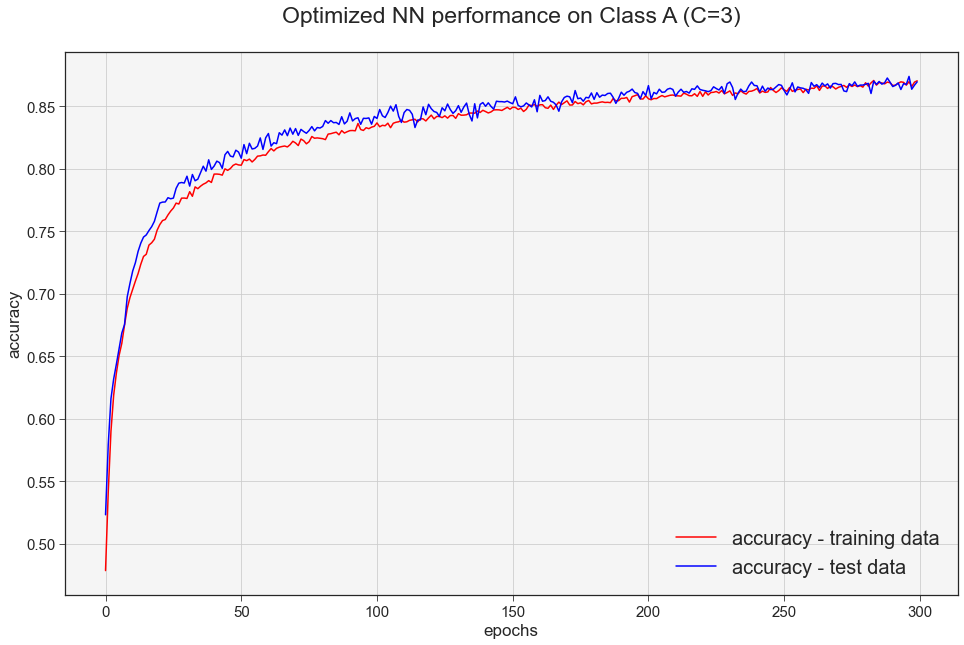

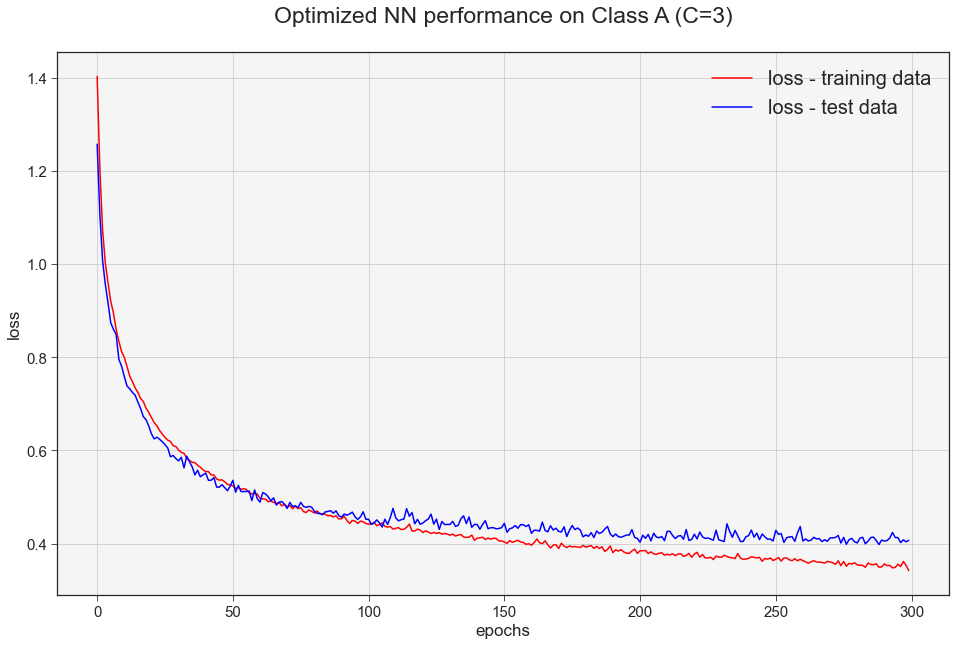

In [41]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(16,10))
    plt.style.use('seaborn-ticks')
    plt.plot(fit.history[obs], 'r', label = obs +' - training data')
    plt.plot(fit.history['val_' + obs], 'b', label = obs + ' - test data')
    plt.title('Optimized NN performance on Class A (C=3)\n', fontsize = 23)
    ax = plt.subplot()
    ax.set_facecolor("whitesmoke")
    plt.xlabel('epochs', fontsize = 17)
    plt.ylabel(obs, fontsize = 17)
    plt.legend(loc = "best", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.grid()
    plt.show()